In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2 
from skimage.feature import local_binary_pattern
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
import pyswarms as ps


In [2]:
# load images of ORL
Images = []
Labels = []
files = glob.glob("./ORL/*.jpg")
files.sort()
for img in files:
    tile= cv2.imread(img)
    tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
    label = img.split("_")[1].split(".")[0]
    Labels.append(int(label))
    Images.append(np.reshape(tile,(70*80)))
    
Images = np.array(Images)
Labels = np.array(Labels)
print("Shapes of Dataset:",Images.shape)

_X_train, _X_test, Y_train, Y_test = train_test_split(Images, Labels, test_size=0.25, stratify=Labels)

pca = PCA()
pca.fit(_X_train)
print("explained variance with 256 Eigen vectors:",sum(pca.explained_variance_ratio_[:256]))
pca = PCA(n_components=256)
pca.fit(_X_train)
X_train = pca.transform(_X_train)
X_test = pca.transform(_X_test)

classifier = KNeighborsClassifier(n_neighbors=3,metric="cosine")
classifier.fit(X_train,Y_train)
classifier.score(X_test,Y_test)

Shapes of Dataset: (410, 5600)
explained variance with 256 Eigen vectors: 0.9937696519443581


0.9223300970873787

In [3]:
# Create an instance of the classifier
classifier = KNeighborsClassifier(n_neighbors=3,metric="cosine")

# Define objective function for each particle
def ParticleFitness(m):
    total_features = 256
    if np.count_nonzero(m) == 0:
        X_subset_train = X_train
        X_subset_test = X_test
    else:
        X_subset_train = X_train[:,m==1]
        X_subset_test = X_test[:,m==1]
    
    classifier.fit(X_subset_train, Y_train)
    P = classifier.score(X_subset_test,Y_test)

    return 1-P

In [4]:
def Fitness(x, alpha=0.88,**k):
    n_particles = x.shape[0]
    j = [ParticleFitness(x[i]) for i in range(n_particles)]
    return np.array(j)

In [6]:
# Initialize swarm, arbitrary
options = {'c1': 1.5, 'c2': 1.6, 'w':0.95, 'k': 100, 'p':2}


# Call instance of PSO
dimensions = 256 # dimensions should be the number of features
optimizer = ps.discrete.BinaryPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(Fitness,iters=500, verbose=2)
optimizer.reset()

2022-02-15 22:38:48,525 - pyswarms.discrete.binary - INFO - Optimize for 500 iters with {'c1': 1.5, 'c2': 1.6, 'w': 0.95, 'k': 100, 'p': 2}
pyswarms.discrete.binary: 100%|██████████████████████████████████████████████████████████████|500/500, best_cost=0.0291
2022-02-15 22:44:49,438 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.029126213592232997, best pos: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0
 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0
 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1
 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1
 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0
 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0]


In [7]:
classifier = KNeighborsClassifier(n_neighbors=3,metric="cosine")


X_selected_features_train = X_train[:,pos==1]  
X_selected_features_test = X_test[:,pos==1]

classifier.fit(X_selected_features_train, Y_train)

subset_performance = (classifier.predict(X_selected_features_test) == Y_test).mean()
print('Subset performance: %.3f' % (subset_performance))

Subset performance: 0.971


In [8]:
print("Count of selected Eigen vectors:",sum(pos))

Count of selected Eigen vectors: 135


In [9]:
print("Explained variance with selected Eigen vectors by PSO:",sum(pca.explained_variance_ratio_[pos==1] ))

Explained variance with selected Eigen vectors by PSO: 0.8097820190313606


In [27]:
_X_train, _X_test, Y_train, Y_test = train_test_split(Images, Labels, test_size=0.25, stratify=Labels)
Accus = []
for i in range(1,min(_X_train.shape)+1):
    pca = PCA(n_components=i)
    pca.fit(_X_train)
    X_train = pca.transform(_X_train)
    X_test = pca.transform(_X_test)

    classifier = KNeighborsClassifier(n_neighbors=3,metric="cosine")
    classifier.fit(X_train,Y_train)
    Accus.append(classifier.score(X_test,Y_test)) 
    if i!=0 and i%10==0:
        print("Passed :",i,max(Accus))

Passed : 10 0.8543689320388349
Passed : 20 0.883495145631068
Passed : 30 0.9223300970873787
Passed : 40 0.9223300970873787
Passed : 50 0.9223300970873787
Passed : 60 0.9223300970873787
Passed : 70 0.9320388349514563
Passed : 80 0.9320388349514563
Passed : 90 0.9320388349514563
Passed : 100 0.9320388349514563
Passed : 110 0.9320388349514563
Passed : 120 0.9320388349514563
Passed : 130 0.9320388349514563
Passed : 140 0.9320388349514563
Passed : 150 0.9320388349514563
Passed : 160 0.9320388349514563
Passed : 170 0.9320388349514563
Passed : 180 0.9320388349514563
Passed : 190 0.9320388349514563
Passed : 200 0.9320388349514563
Passed : 210 0.9320388349514563
Passed : 220 0.9320388349514563
Passed : 230 0.9320388349514563
Passed : 240 0.9320388349514563
Passed : 250 0.9320388349514563
Passed : 260 0.9320388349514563
Passed : 270 0.9320388349514563
Passed : 280 0.9320388349514563
Passed : 290 0.9320388349514563
Passed : 300 0.9320388349514563


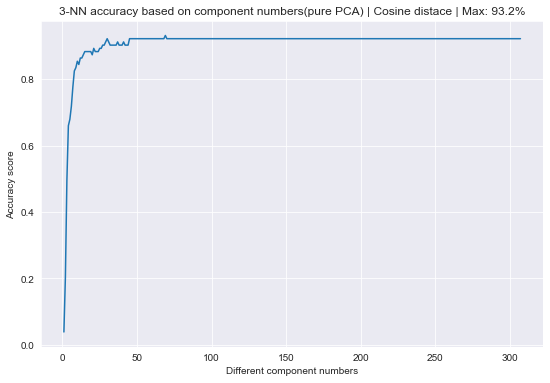

In [28]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(list(range(1,min(_X_train.shape)+1)),Accus)
plt.title("3-NN accuracy based on component numbers(pure PCA) | Cosine distace | Max: {0}%".format(round(max(Accus)*100,2)))
plt.xlabel("Different component numbers")
plt.ylabel("Accuracy score")
plt.show()

In [29]:
with open('PSO-PCA-Positions.npy', 'wb') as f:
    np.save(f, pos)